# MNIST — Interpolation vs Generalization with (1-NN / k-NN / wiNN)

Objectifs :
- Charger MNIST (10 classes), normaliser et aplatir les images (784 dims).
- Créer du bruit de labels sur le TRAIN uniquement (p_noise), TEST reste clean.
- Comparer :
  - 1-NN (interpolant)
  - k-NN (k>1 non-interpolant)
  - wiNN (interpolant avec poids singuliers, paramètre delta)
- Étudier :
  - test error vs k (fixe p_noise)
  - robustesse au bruit (test error vs p_noise)
  - sensibilité à delta (test error vs delta)
- Option : PCA pour réduire la dimension et accélérer.


In [3]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors

plt.rcParams["figure.dpi"] = 120
plt.rcParams["font.size"] = 10


In [4]:
def accuracy(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    return (y_true == y_pred).mean()

def mean_std(x):
    x = np.asarray(x, dtype=float)
    return x.mean(), x.std(ddof=1) if len(x) > 1 else (x.mean(), 0.0)

def add_label_noise_multiclass(y, p_noise, rng, n_classes=10):
    """
    Symmetric label noise for multiclass.
    With prob p_noise, replace label by a random different class.
    """
    y = np.asarray(y).copy()
    if p_noise <= 0:
        return y
    mask = rng.random(len(y)) < p_noise
    if mask.any():
        y_noisy = y[mask]
        # pick random labels != current
        new = rng.integers(0, n_classes, size=y_noisy.shape[0])
        # ensure different
        same = (new == y_noisy)
        while same.any():
            new[same] = rng.integers(0, n_classes, size=same.sum())
            same = (new == y_noisy)
        y[mask] = new
    return y


In [5]:
# MNIST via OpenML
mnist = fetch_openml("mnist_784", version=1, as_frame=False)
X = mnist["data"].astype(np.float32) / 255.0  # normalize [0,1]
y = mnist["target"].astype(int)

print("X shape:", X.shape, "y shape:", y.shape, "classes:", np.unique(y))


X shape: (70000, 784) y shape: (70000,) classes: [0 1 2 3 4 5 6 7 8 9]


In [6]:
# Split clean
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=10000, random_state=0, stratify=y
)

# Subsample train for speed (change if you want more accuracy)
n_train = 12000
rng = np.random.default_rng(0)
idx = rng.choice(len(X_train_full), size=n_train, replace=False)

X_train = X_train_full[idx]
y_train_clean = y_train_full[idx]

print("Train:", X_train.shape, "Test:", X_test.shape)


Train: (12000, 784) Test: (10000, 784)


In [14]:
USE_PCA = True
PCA_DIM = 50  # try 30, 50, 80

if USE_PCA:
    pca = PCA(n_components=PCA_DIM, random_state=0)
    X_train_p = pca.fit_transform(X_train)
    X_test_p  = pca.transform(X_test)
    print("PCA:", X_train_p.shape, X_test_p.shape, "Explained var:", pca.explained_variance_ratio_.sum())
else:
    X_train_p, X_test_p = X_train, X_test


PCA: (12000, 50) (10000, 50) Explained var: 0.8261318


In [7]:
class KNNClassifierMC:
    def __init__(self, k=1, n_classes=10):
        self.k = int(k)
        self.n_classes = int(n_classes)
        self.nn = None
        self.X_train = None
        self.y_train = None

    def fit(self, X, y):
        self.X_train = np.asarray(X)
        self.y_train = np.asarray(y).astype(int)
        self.nn = NearestNeighbors(n_neighbors=self.k, algorithm="auto")
        self.nn.fit(self.X_train)
        return self

    def predict(self, X):
        X = np.asarray(X)
        _, idxs = self.nn.kneighbors(X, return_distance=True)
        neigh = self.y_train[idxs]  # (n_test, k)
        # majority vote
        yhat = np.zeros(len(X), dtype=int)
        for i in range(len(X)):
            counts = np.bincount(neigh[i], minlength=self.n_classes)
            yhat[i] = counts.argmax()
        return yhat


In [8]:
class WiNNClassifierMC:
    def __init__(self, k=50, delta=1.0, n_classes=10, eps=1e-12, zero_thr=1e-12):
        self.k = int(k)
        self.delta = float(delta)
        self.n_classes = int(n_classes)
        self.eps = float(eps)
        self.zero_thr = float(zero_thr)
        self.nn = None
        self.X_train = None
        self.y_train = None

    def fit(self, X, y):
        self.X_train = np.asarray(X)
        self.y_train = np.asarray(y).astype(int)
        self.nn = NearestNeighbors(n_neighbors=self.k + 1, algorithm="auto")
        self.nn.fit(self.X_train)
        return self

    def predict(self, X):
        X = np.asarray(X)
        dists_all, idxs_all = self.nn.kneighbors(X, return_distance=True)

        dists_k = dists_all[:, :self.k]
        idxs_k  = idxs_all[:, :self.k]
        r = dists_all[:, self.k]

        neigh_y = self.y_train[idxs_k]  # (n_test, k)

        # interpolation safeguard: if nearest neighbor distance ~ 0 => exact label
        zero_nn = (dists_k[:, 0] < self.zero_thr)

        r_safe = np.maximum(r, self.eps)
        t = np.maximum(dists_k / r_safe[:, None], self.eps)
        w = t ** (-self.delta)

        yhat = np.zeros(len(X), dtype=int)
        for i in range(len(X)):
            if zero_nn[i]:
                yhat[i] = neigh_y[i, 0]
                continue
            # weighted vote
            scores = np.zeros(self.n_classes, dtype=float)
            for j in range(self.k):
                scores[neigh_y[i, j]] += w[i, j]
            yhat[i] = scores.argmax()

        return yhat


In [9]:
def eval_once(Xtr, ytr, Xte, yte, model):
    model.fit(Xtr, ytr)
    yhat_tr = model.predict(Xtr)
    yhat_te = model.predict(Xte)
    return {
        "train_err": 1.0 - accuracy(ytr, yhat_tr),
        "test_err":  1.0 - accuracy(yte, yhat_te),
    }

def make_noisy_train(y_clean, p_noise, seed, n_classes=10):
    rng = np.random.default_rng(seed)
    return add_label_noise_multiclass(y_clean, p_noise, rng, n_classes=n_classes)


## Sanity check
- 1-NN et wiNN doivent avoir train_err ~ 0 (interpolants).
- k-NN (k>1) aura train_err > 0 si le train est bruité.


In [15]:
p_noise = 0.2
y_train_noisy = make_noisy_train(y_train_clean, p_noise, seed=0)

models = {
    "1-NN": KNNClassifierMC(k=1),
    "k-NN (k=25)": KNNClassifierMC(k=25),
    "wiNN (k=25, delta=1.0)": WiNNClassifierMC(k=25, delta=1.0),
}

for name, m in models.items():
    res = eval_once(X_train_p, y_train_noisy, X_test_p, y_test, m)
    print(f"{name:24s} train_err={res['train_err']:.4f} test_err={res['test_err']:.4f}")


1-NN                     train_err=0.0000 test_err=0.2290
k-NN (k=25)              train_err=0.2394 test_err=0.0528
wiNN (k=25, delta=1.0)   train_err=0.0000 test_err=0.0507


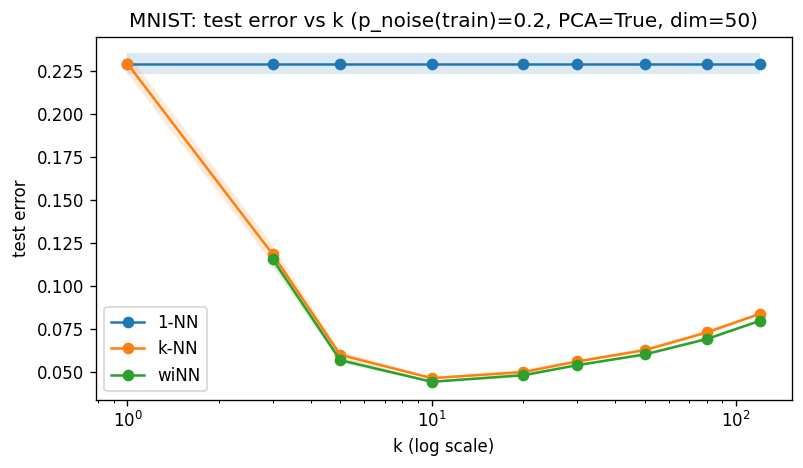

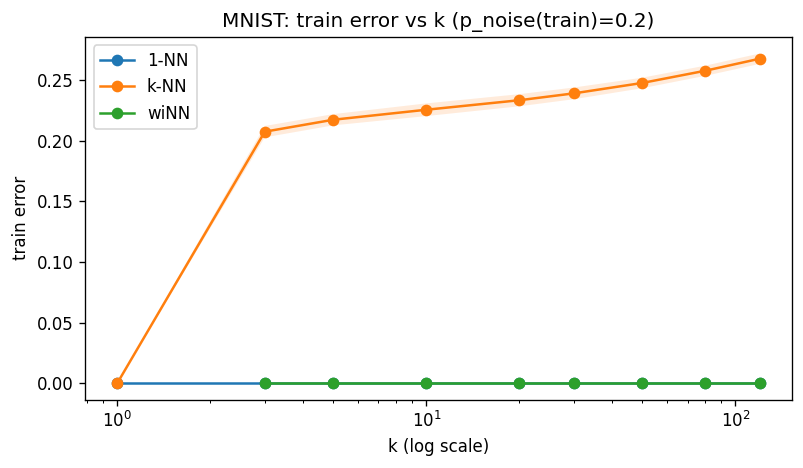

In [16]:
deltas = [1.0]          # wiNN delta fixed here
p_noise = 0.2
k_grid = [1, 3, 5, 10, 20, 30, 50, 80, 120]
seeds = list(range(10))  # increase to 20 if you have time

# store curves
curves_test = {"1-NN": [], "k-NN": [], "wiNN": []}
curves_test_std = {"1-NN": [], "k-NN": [], "wiNN": []}

curves_train = {"1-NN": [], "k-NN": [], "wiNN": []}
curves_train_std = {"1-NN": [], "k-NN": [], "wiNN": []}

delta_fixed = 1.0

for k in k_grid:
    test_1nn, test_knn, test_winn = [], [], []
    train_1nn, train_knn, train_winn = [], [], []

    for s in seeds:
        ytr = make_noisy_train(y_train_clean, p_noise, seed=s)

        r = eval_once(X_train_p, ytr, X_test_p, y_test, KNNClassifierMC(k=1))
        train_1nn.append(r["train_err"]); test_1nn.append(r["test_err"])

        r = eval_once(X_train_p, ytr, X_test_p, y_test, KNNClassifierMC(k=k))
        train_knn.append(r["train_err"]); test_knn.append(r["test_err"])

        if k >= 2:
            r = eval_once(X_train_p, ytr, X_test_p, y_test, WiNNClassifierMC(k=k, delta=delta_fixed))
            train_winn.append(r["train_err"]); test_winn.append(r["test_err"])
        else:
            train_winn.append(np.nan); test_winn.append(np.nan)

    m, sd = mean_std(test_1nn);  curves_test["1-NN"].append(m);  curves_test_std["1-NN"].append(sd)
    m, sd = mean_std(test_knn);  curves_test["k-NN"].append(m);  curves_test_std["k-NN"].append(sd)
    m, sd = mean_std(test_winn); curves_test["wiNN"].append(m);  curves_test_std["wiNN"].append(sd)

    m, sd = mean_std(train_1nn);  curves_train["1-NN"].append(m);  curves_train_std["1-NN"].append(sd)
    m, sd = mean_std(train_knn);  curves_train["k-NN"].append(m);  curves_train_std["k-NN"].append(sd)
    m, sd = mean_std(train_winn); curves_train["wiNN"].append(m);  curves_train_std["wiNN"].append(sd)

# Plot TEST
plt.figure(figsize=(6.8, 4))
for name in ["1-NN", "k-NN", "wiNN"]:
    mean = np.array(curves_test[name], dtype=float)
    std  = np.array(curves_test_std[name], dtype=float)
    plt.plot(k_grid, mean, marker="o", label=name)
    plt.fill_between(k_grid, mean-std, mean+std, alpha=0.15)
plt.xscale("log")
plt.xlabel("k (log scale)")
plt.ylabel("test error")
plt.title(f"MNIST: test error vs k (p_noise(train)={p_noise}, PCA={USE_PCA}, dim={PCA_DIM if USE_PCA else 784})")
plt.legend()
plt.tight_layout()
plt.show()

# Plot TRAIN
plt.figure(figsize=(6.8, 4))
for name in ["1-NN", "k-NN", "wiNN"]:
    mean = np.array(curves_train[name], dtype=float)
    std  = np.array(curves_train_std[name], dtype=float)
    plt.plot(k_grid, mean, marker="o", label=name)
    plt.fill_between(k_grid, mean-std, mean+std, alpha=0.15)
plt.xscale("log")
plt.xlabel("k (log scale)")
plt.ylabel("train error")
plt.title(f"MNIST: train error vs k (p_noise(train)={p_noise})")
plt.legend()
plt.tight_layout()
plt.show()


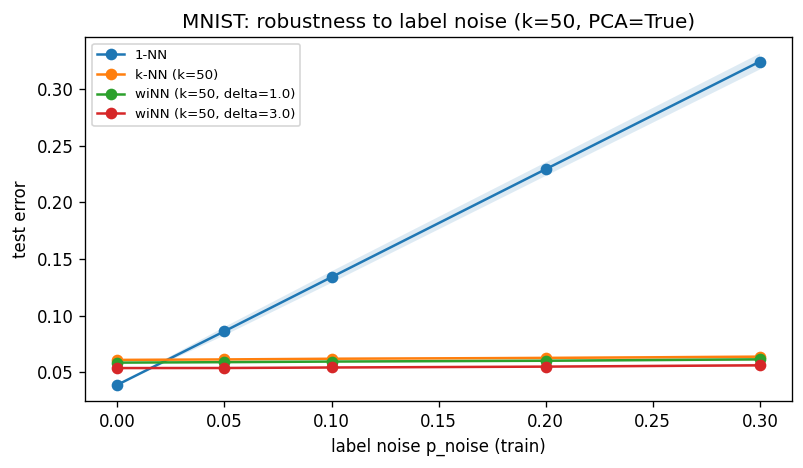

In [17]:
k_fixed = 50
noise_grid = [0.0, 0.05, 0.1, 0.2, 0.3]
seeds = list(range(10))

delta_list = [1.0, 3.0]

means = {"1-NN": [], "k-NN": []}
stds  = {"1-NN": [], "k-NN": []}
for delta in delta_list:
    means[f"wiNN(d={delta})"] = []
    stds[f"wiNN(d={delta})"]  = []

for p_noise in noise_grid:
    test_1nn, test_knn = [], []
    test_w = {delta: [] for delta in delta_list}

    for s in seeds:
        ytr = make_noisy_train(y_train_clean, p_noise, seed=s)

        test_1nn.append(eval_once(X_train_p, ytr, X_test_p, y_test, KNNClassifierMC(k=1))["test_err"])
        test_knn.append(eval_once(X_train_p, ytr, X_test_p, y_test, KNNClassifierMC(k=k_fixed))["test_err"])

        for delta in delta_list:
            test_w[delta].append(eval_once(X_train_p, ytr, X_test_p, y_test, WiNNClassifierMC(k=k_fixed, delta=delta))["test_err"])

    m, sd = mean_std(test_1nn); means["1-NN"].append(m); stds["1-NN"].append(sd)
    m, sd = mean_std(test_knn); means["k-NN"].append(m); stds["k-NN"].append(sd)
    for delta in delta_list:
        m, sd = mean_std(test_w[delta])
        means[f"wiNN(d={delta})"].append(m)
        stds[f"wiNN(d={delta})"].append(sd)

plt.figure(figsize=(6.8, 4))
plt.plot(noise_grid, means["1-NN"], marker="o", label="1-NN")
plt.fill_between(noise_grid, np.array(means["1-NN"])-np.array(stds["1-NN"]), np.array(means["1-NN"])+np.array(stds["1-NN"]), alpha=0.15)

plt.plot(noise_grid, means["k-NN"], marker="o", label=f"k-NN (k={k_fixed})")
plt.fill_between(noise_grid, np.array(means["k-NN"])-np.array(stds["k-NN"]), np.array(means["k-NN"])+np.array(stds["k-NN"]), alpha=0.15)

for delta in delta_list:
    key = f"wiNN(d={delta})"
    plt.plot(noise_grid, means[key], marker="o", label=f"wiNN (k={k_fixed}, delta={delta})")
    plt.fill_between(noise_grid, np.array(means[key])-np.array(stds[key]), np.array(means[key])+np.array(stds[key]), alpha=0.15)

plt.xlabel("label noise p_noise (train)")
plt.ylabel("test error")
plt.title(f"MNIST: robustness to label noise (k={k_fixed}, PCA={USE_PCA})")
plt.legend(fontsize=8)
plt.tight_layout()
plt.show()


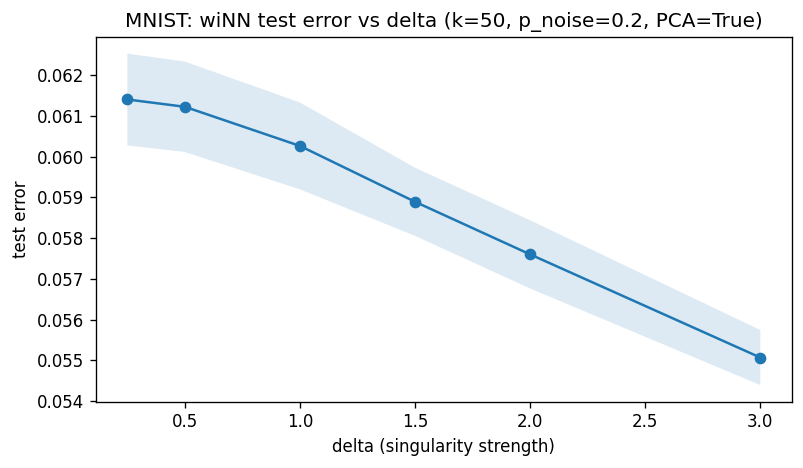

In [18]:
k_fixed = 50
p_noise = 0.2
delta_grid = [0.25, 0.5, 1.0, 1.5, 2.0, 3.0]
seeds = list(range(10))

means_delta, std_delta = [], []

for delta in delta_grid:
    errs = []
    for s in seeds:
        ytr = make_noisy_train(y_train_clean, p_noise, seed=s)
        r = eval_once(X_train_p, ytr, X_test_p, y_test, WiNNClassifierMC(k=k_fixed, delta=delta))
        errs.append(r["test_err"])
    m, sd = mean_std(errs)
    means_delta.append(m)
    std_delta.append(sd)

plt.figure(figsize=(6.8, 4))
plt.plot(delta_grid, means_delta, marker="o")
plt.fill_between(delta_grid, np.array(means_delta)-np.array(std_delta), np.array(means_delta)+np.array(std_delta), alpha=0.15)
plt.xlabel("delta (singularity strength)")
plt.ylabel("test error")
plt.title(f"MNIST: wiNN test error vs delta (k={k_fixed}, p_noise={p_noise}, PCA={USE_PCA})")
plt.tight_layout()
plt.show()
